Food image classification 
======

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [2]:
#Set parameters here:
#The initial batch size used is 64 for 224x224 images. ResNet-50 model is used as a starting point for the transfer learning process.
bs = 25
arch = models.resnet50

img_size = 224

In [3]:
!wget 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'

--2019-07-19 16:15:35--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Auflösen des Hostnamens data.vision.ee.ethz.ch (data.vision.ee.ethz.ch) … 129.132.52.162
Verbindungsaufbau zu data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [folgend]
--2019-07-19 16:15:35--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Verbindungsaufbau zu data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 4996278331 (4.7G) [application/x-gzip]
Wird in »food-101.tar.gz« gespeichert.

food-101.tar.gz     100%[===================>]   4.65G  5.59MB/s    in 14m 27s 

2019-07-19 16:30:02 (5.50 MB/s) - »food-101.tar.gz« gespeichert [4996278331/4996278331]



In [4]:
#work ;) 
import tarfile
fname = "food-101.tar.gz"
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [5]:
path = Path('food-101') #untar creates food-101 subdirectory
path_img = path/'images'

train_path = 'food-101/meta/train.txt'
test_path = 'food-101/meta/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])


data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .random_split_by_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/home/mateusz/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:212: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


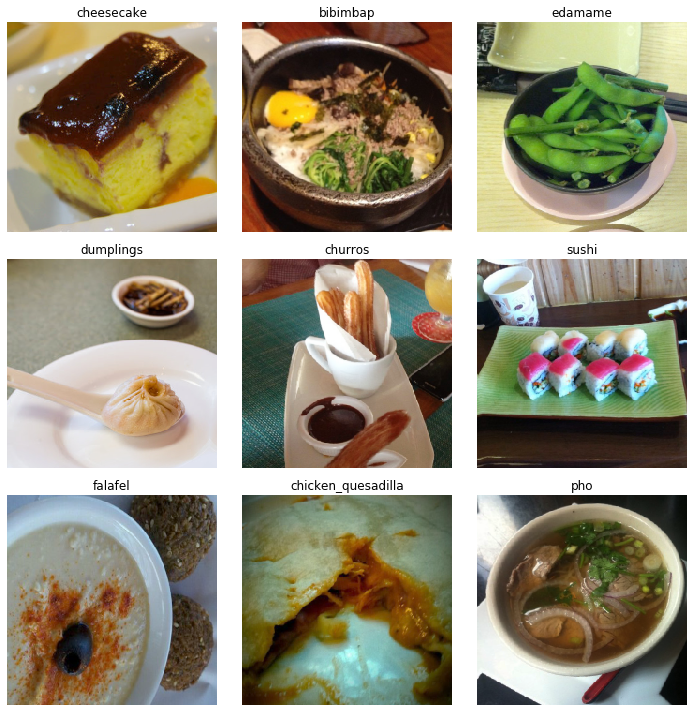

In [6]:

data.show_batch(rows=3, figsize=(10, 10))

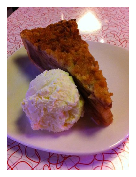

In [7]:
img = open_image('food-101/images/apple_pie/157083.jpg')
img.show()

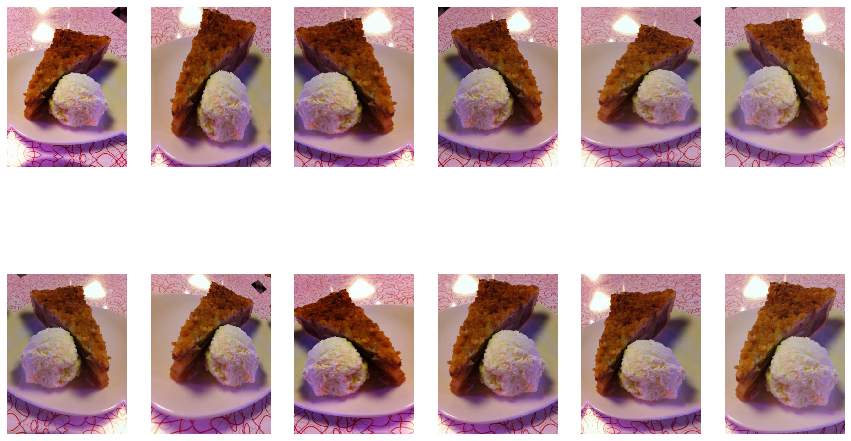

In [8]:
rows = 2
cols = 6
width = 15
height = 9


[img.apply_tfms(get_transforms()[0]).show(ax=ax) for i,ax in enumerate(plt.subplots(
    rows,cols,figsize=(width,height))[1].flatten())];

In [9]:
print(data.classes);
print(data.c)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [10]:
top_5 = partial(top_k_accuracy, k=5)

learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)

In [11]:
learn.lr_find()# +12 hours in this only line of code :(

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 5.75E-03


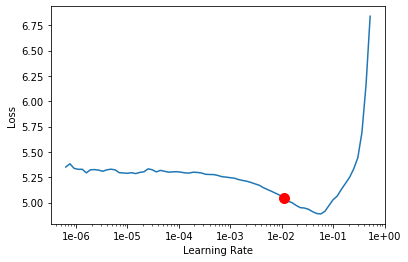

In [12]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.350354,4.887010,0.008911,0.047129,12:10
1,5.234975,4.885517,0.009505,0.047525,12:12
2,5.328223,4.888036,0.009109,0.047855,12:16
3,5.283746,4.891571,0.009439,0.047591,12:27
4,5.279323,4.889086,0.009637,0.047129,12:51


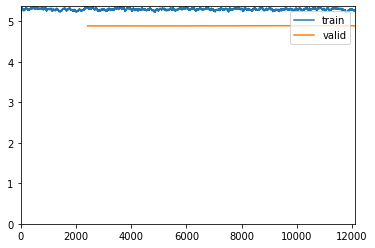

In [13]:
lr = 1e-0212
learn.fit_one_cycle(5, slice(lr))
learn.save('food-101-test-e5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 6.31E-08


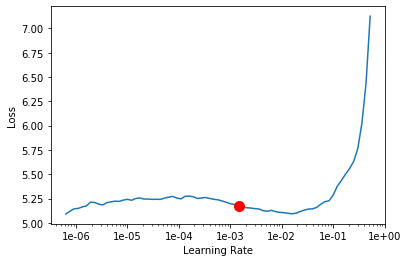

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.878381,1.461513,0.629109,0.856964,17:34
1,1.411251,1.161715,0.694521,0.899142,17:49
2,1.097482,0.991590,0.736700,0.919340,17:15
3,0.754856,0.814515,0.786799,0.940924,17:48
4,0.576991,0.788923,0.792343,0.942244,17:21


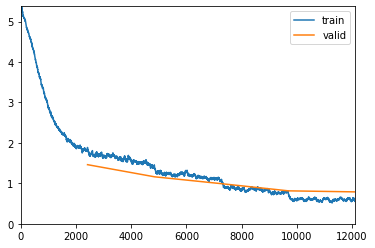

In [15]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('food-101-test-e10')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.624888,0.843162,0.779208,0.937492,17:10
1,0.709935,0.867091,0.779736,0.934785,17:16
2,0.537349,0.869744,0.784950,0.935248,17:12
3,0.355138,0.828210,0.796106,0.939736,17:08
4,0.365910,0.831041,0.797162,0.940396,17:16


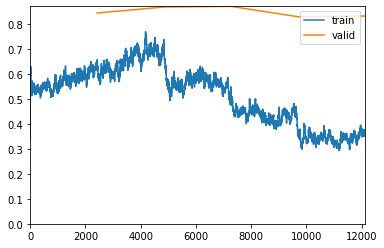

In [16]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e15')